In [2]:
# !pip3 install sklearn
# Data download
from scipy.io import loadmat
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Find the CUDA version PyTorch was installed with
!python -c "import torch; print(torch.version.cuda)"

11.8


In [4]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.0.1+cu118


In [5]:
# Use the above information to fill in the http address below
%%capture
!pip install ogb pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric

In [6]:
import torch
import pickle
import random as rd
import numpy as np
import scipy.sparse as sp
from scipy.io import loadmat
import copy as cp
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
from collections import defaultdict


def sparse_to_adjlist(sp_matrix, filename):
	"""
	Transfer sparse matrix to adjacency list
	:param sp_matrix: the sparse matrix
	:param filename: the filename of adjlist
	"""
	# add self loop
	homo_adj = sp_matrix + sp.eye(sp_matrix.shape[0])
	# create adj_list
	adj_lists = defaultdict(set)
	edges = homo_adj.nonzero()
	for index, node in enumerate(edges[0]):
		adj_lists[node].add(edges[1][index])
		adj_lists[edges[1][index]].add(node)
	with open(filename, 'wb') as file:
		pickle.dump(adj_lists, file)
	file.close()

Note on data: The data files can be found in the repository under the chapter 5 directory. In the colab environment, these files can be uploaded to your folder of choice. Once the folder is chosen, adjust the 'prefix' variables accordingly.

In [14]:
!unzip '/content/YelpChi.zip'


Archive:  /content/YelpChi.zip
  inflating: yelp_homo_adjlists.pickle  
  inflating: yelp_rsr_adjlists.pickle  
  inflating: yelp_rtr_adjlists.pickle  
  inflating: yelp_rur_adjlists.pickle  
  inflating: YelpChi.mat             
  inflating: __MACOSX/._YelpChi.mat  


In [15]:
prefix = '/content/'
# data_file = loadmat(prefix +  'YelpChi.mat')
data_file = loadmat('/content/YelpChi.mat')
# data_file = loadmat('/content/YelpChi.mat', verify_compressed_data_integrity=False)


labels = data_file['label'].flatten()
features = data_file['features'].todense().A

yelp_homo = data_file['homo'] #C
sparse_to_adjlist(yelp_homo, prefix + 'yelp_homo_adjlists.pickle') #C


# load the preprocessed adj_lists
with open(prefix + 'yelp_homo_adjlists.pickle', 'rb') as file:
    homogenous = pickle.load(file)
file.close()


In [16]:
# shape of feature dataset
print(f'number of entries = {features.shape[0]}, number of features = {features.shape[1]}')

number of entries = 45954, number of features = 32


In [17]:
# number of classes and percentage attributed
print(f'number of classes  = {np.unique(labels)}')
print(f'percentage false = {100*labels.sum()/len(labels):.2f}%')

# low percentage of false shows a high class imbalance

number of classes  = [0 1]
percentage false = 14.53%


In [18]:
#Note current data is float64 and int64. Both need to be translated into torch tensors when using pytorch geometric
print(f'features dtype = {features.dtype}, \n' +
      f'label dtype = {labels.dtype}')


features dtype = float64, 
label dtype = int64


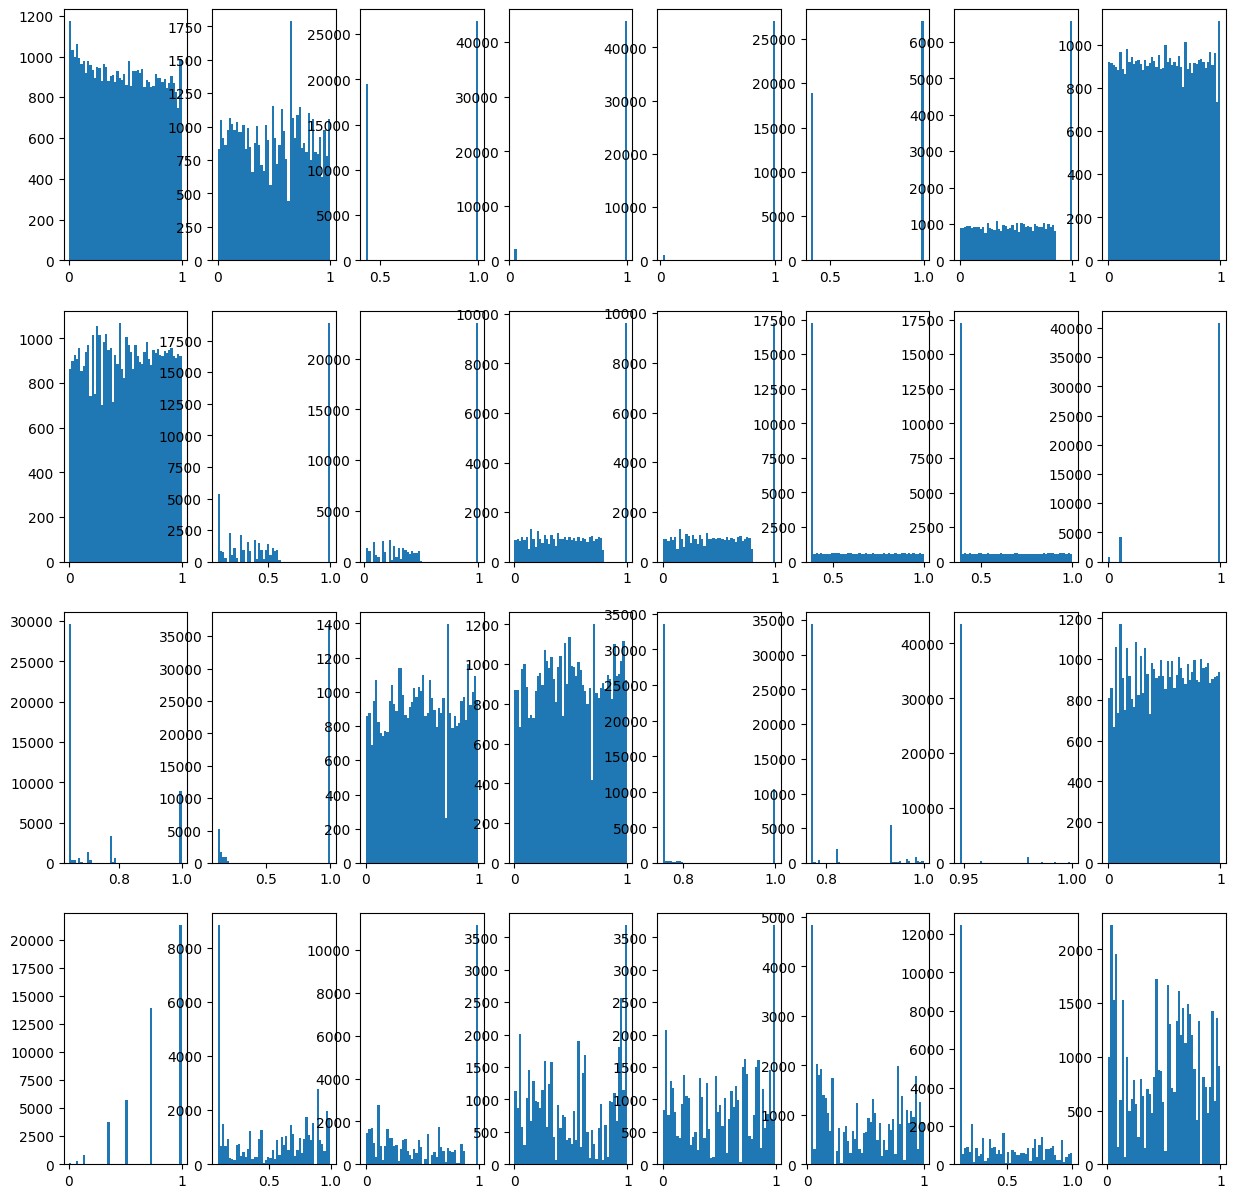

In [19]:
#plot distribution of features (though features are left as is)
fig,ax = plt.subplots(4,8,figsize=(15,15))
for i in range(4):
    for j in range(8):
        ax[i,j].hist(features[:,8*i+j], 50)


In [20]:
# split data into test and train
from sklearn.model_selection import train_test_split
split = 0.2
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size = split,
                                                                    stratify=labels,
                                                                    random_state = 99)


In [21]:
print(ytrain.sum()/len(ytrain))
print(ytest.sum()/len(ytest))


0.14530914234420478
0.14525078881514525


In [22]:
#double check shapes
print(f'Required shape is {int(len(features)*(1-split))}')
print(f'xtrain shape = {xtrain.shape}, xtest shape = {xtest.shape}')
print(f'Correct split = {int(len(features)*(1-split)) == xtrain.shape[0]}')

Required shape is 36763
xtrain shape = (36763, 32), xtest shape = (9191, 32)
Correct split = True


In [23]:
# Apply logistic regression for first baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score

clf = LogisticRegression(random_state=0).fit(xtrain, ytrain)
ypred = clf.predict_proba(xtest)[:,1]
acc = roc_auc_score(ytest,ypred)

print(f"Model accuracy (logression) = {100*acc:.2f}%")

Model accuracy (logression) = 75.89%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


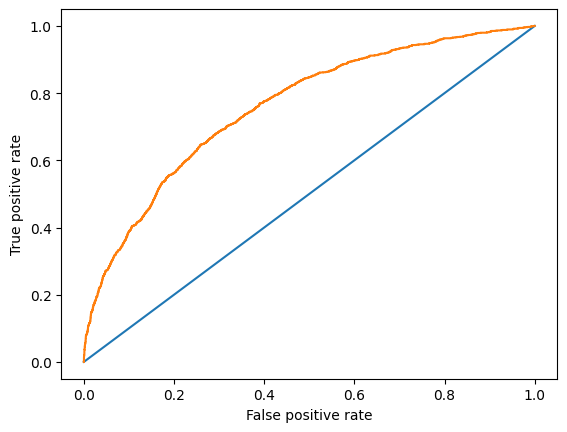

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,ypred)

plt.figure(1)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [25]:
# ## Apply XGBoost for second baseline
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()

In [26]:
xgb_classifier.fit(xtrain,ytrain)
ypred2 = xgb_classifier.predict_proba(xtest)[:,1]
acc = roc_auc_score(ytest,ypred2)

print(f"Model accuracy (XGBoost) = {100*acc:.2f}%")

Model accuracy (XGBoost) = 95.71%


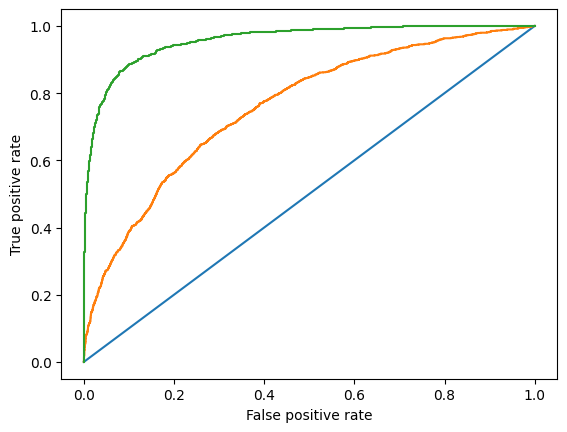

In [27]:
fpr2, tpr2, _ = roc_curve(ytest,ypred2)

plt.figure(1)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [28]:
# Apply MLP for third baseline
# import sys
# !{sys.executable} -m pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=[128,256]):
        super(MLP, self).__init__()
#         torch.manual_seed(2022)
        self.lin1 = nn.Linear(in_channels,hidden_channels[0])
        self.lin2 = nn.Linear(hidden_channels[0],hidden_channels[1])
        self.lin3 = nn.Linear(hidden_channels[1],out_channels)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        x = torch.sigmoid(x)

        return x


In [29]:
model = MLP(in_channels = features.shape[1], out_channels = 1)

print(model)

epochs = 100
lr = 0.001
wd = 5e-4
n_classes = 2
n_samples = len(ytrain)

w= ytrain.sum()/(n_samples - ytrain.sum()) #for class inbalance

optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
criterion = torch.nn.BCELoss()

xtrain = torch.tensor(xtrain).float()
ytrain = torch.tensor(ytrain)



MLP(
  (lin1): Linear(in_features=32, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=1, bias=True)
)


In [30]:
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model.forward(xtrain)

    #loss
    loss = criterion(output, ytrain.reshape(-1,1).float())
    loss.backward()
    losses.append(loss.item())

    #prediction
    ypred3 = model(torch.tensor(xtest,dtype=torch.float32))

    #typical accuracy score
    acc = (ypred3.reshape(-1).detach().numpy().round() == ytest).mean()
    print(f'Epoch {epoch} | Loss {loss.item():6.2f} | Accuracy = {100*acc:6.3f}%', end='\r')

    optimizer.step()


In [31]:
print(f'Epoch {epoch} | Loss {loss.item():6.2f} | Accuracy = {100*acc:6.3f}%', end='\r')


In [32]:
print(f'{100*acc:6.3f}%')

85.834%


In [33]:
model = MLP(in_channels = features.shape[1], out_channels = 1)
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
#


In [34]:
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(xtrain)

    #loss
    loss = criterion(output, ytrain.reshape(-1,1).float())
    loss.backward()
    losses.append(loss.item())

    #prediction
    ypred3 = model(torch.tensor(xtest,dtype=torch.float32))

    #roc_score
    acc = roc_auc_score(ytest,ypred3.detach().numpy())
    print(f'Epoch {epoch} | Loss {loss.item():6.2f} | Accuracy = {100*acc:6.3f}% | # True Labels = {ypred3.detach().numpy().round().sum()}', end='\r')

    optimizer.step()


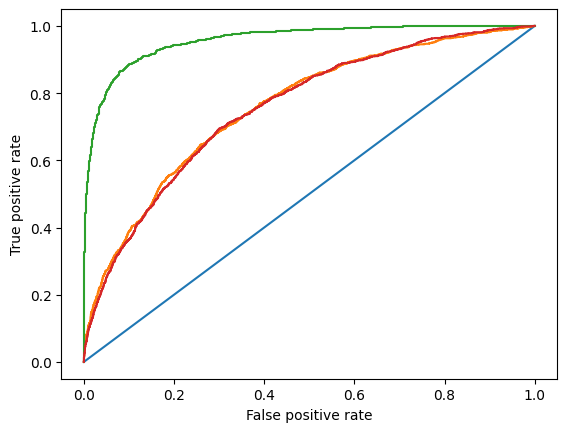

In [35]:
fpr, tpr, _ = roc_curve(ytest,ypred)
fpr3, tpr3, _ = roc_curve(ytest,ypred3.detach().numpy())

plt.figure(1)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()